# Assignment 7: Explainable Deep Learning

Kelly Tong

Link to Colab: https://colab.research.google.com/drive/1YqeD_UqAI2Ex_HDDKr0ksxkp8ZvnAFfz#scrollTo=yFJKWU7MOYZq

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kelly0604/Assignment7_ExplainableDL/blob/main/Assignment7_ExplainableDL.ipynb)

In [1]:
# Link to Github
!git clone https://github.com/Kelly0604/Assignment7_ExplainableDL.git
%cd /content/Assignment7_ExplainableDL
%ls
# update
!git pull

fatal: destination path 'Assignment7_ExplainableDL' already exists and is not an empty directory.
/content/Assignment7_ExplainableDL
README.md
Already up to date.


In [2]:
!pip install numpy==1.25.2 matplotlib==3.7.1 tensorflow==2.14.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
 

In [2]:
# Basic
import numpy as np
import matplotlib.pyplot as plt

# Model Utils
import tensorflow as tf

# Data Utils
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from keras.utils import get_file
import json

## Hypothesis

In this notebook, I will focus on testing the hypothesis below:

### H0 (Null Hypothesis):
The ResNet50 model does not show significant differentiation between the background and the object item in the image.

#### H1 (Alternative Hypothesis):
The ResNet50 model demonstrates significant differentiation between the background and the object item in the image.

## Approach

1. Selecting Model: ResNet50 Model from TensorFlow package is imported and used.
2. Dataset: The ResNet50 Model has already been trained o the ImageNet dataset. Selected images from the ImageNetV2 dataset will be used by altering the image index and downloading the dataset from "image_class_index.json" file.
3. Method to Explain this Deep Learning Model: Saliency Map is used to explain this ResNet50 Model. It is chosen due to its ability in highlighting the most critical regions (pixels) related to the model's prediction and decision.
4. Experiment: Different images are experimented and both the original image as well as the saliency map are printed for view and comparison.

## Generate Saliency Map

In [3]:
# Function to generate a saliency map for an input image based on a given model

def generate_saliency_map(model, img):
    # Convert the input image to a TensorFlow variable
    x = tf.Variable(img)

    # Add an extra dimension to the image tensor to match the model's input shape
    x = tf.expand_dims(x, axis=0)

    # Preprocess the image according to ResNet50 requirements
    x = tf.keras.applications.resnet50.preprocess_input(x)

    # Create a gradient tape context to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor to calculate gradients
        tape.watch(x)

        # Forward pass: get model predictions for the input image
        preds = model(x)

        # Find the index of the highest predicted class probability
        top_pred_index = tf.argmax(preds[0])

    # Calculate the gradients of the top prediction with respect to the input image
    grads = tape.gradient(preds, x)

    # Compute the saliency map by taking the maximum absolute gradient across color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    # Return the saliency map and the index of the top predicted class as a numpy array
    return saliency, top_pred_index.numpy()

In [10]:
index = 10

# Load ResNet50 pre-trained model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

# Load dataset from ImageNetV2
dataset, info = tfds.load('imagenet_v2', with_info=True, split="test[:5%]", as_supervised=True)
for img, label in dataset.take(index):
    img = tf.image.resize(img, (224, 224))
    img = img.numpy().astype(np.float32)

# Download the ImageNet class index file
class_index_path = get_file('imagenet_class_index.json', 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')

# Load ImageNet class labels
with open(class_index_path) as f:
    class_idx = json.load(f)

In [11]:
# Generate saliency map
saliency_map, top_pred_index = generate_saliency_map(model, img)

# Map the index to class label
predicted_class = class_idx[str(top_pred_index)][1]

### First Image Tested

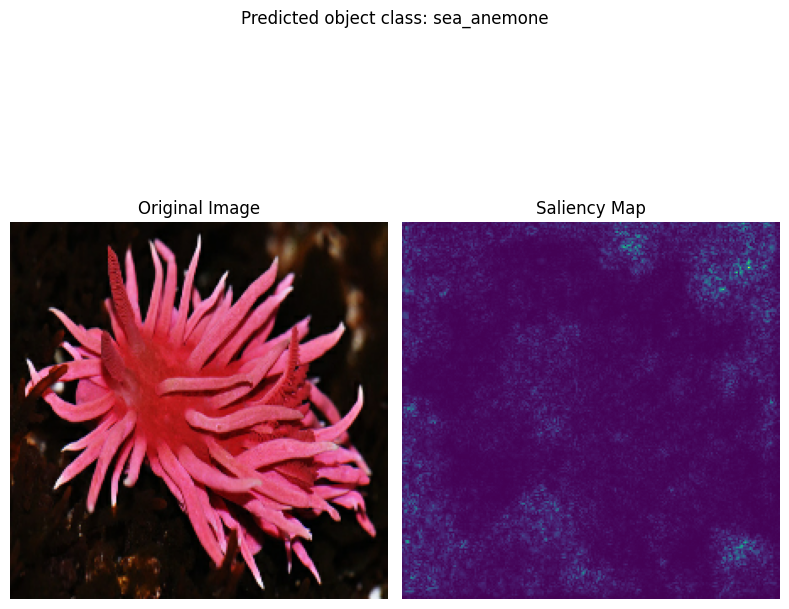

In [12]:
# Display the original image
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.tight_layout()

# Display the saliency map
plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='viridis')
plt.title("Saliency Map")
plt.suptitle(f"Predicted object class: {predicted_class}")
plt.axis('off')
plt.tight_layout()

plt.show()

#### Explanation
The first image has an index of 10. It is classified as a sea anemone. The original image is shown on the left and the saliency map is shown on the right hand side above. We can see from the highlighted area that the classification result is mainly contributed by the background. The actual object item here (the sea anemone) has mostly dark color on the map, suggestig that the object item does not contribute as much to the decision making. This also indicates that the model can distinguish between the background and the object item.

### Second Image Tested

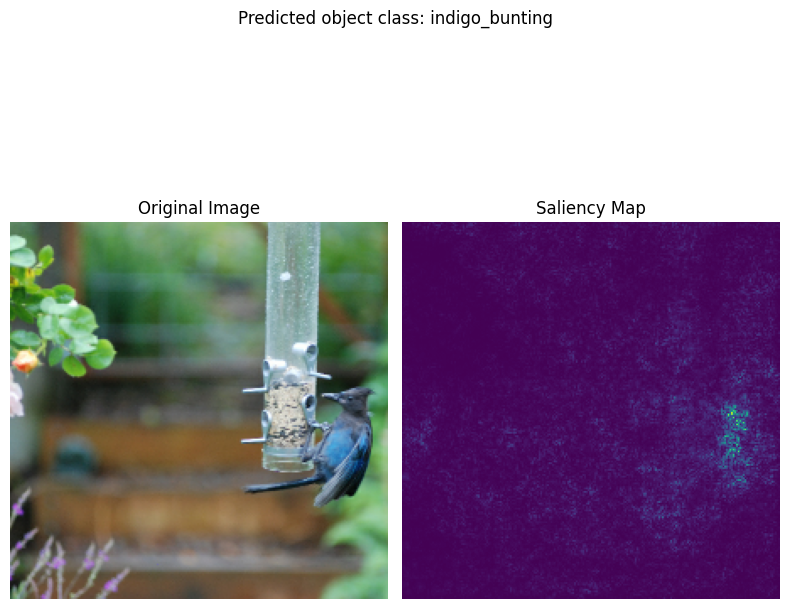

In [17]:
index = 28

# Load ResNet50 pre-trained model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

# Load dataset from ImageNetV2
dataset, info = tfds.load('imagenet_v2', with_info=True, split="test[:5%]", as_supervised=True)
for img, label in dataset.take(index):
    img = tf.image.resize(img, (224, 224))
    img = img.numpy().astype(np.float32)

# Download the ImageNet class index file
class_index_path = get_file('imagenet_class_index.json', 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')

# Load ImageNet class labels
with open(class_index_path) as f:
    class_idx = json.load(f)

# Generate saliency map
saliency_map, top_pred_index = generate_saliency_map(model, img)

# Map the index to class label
predicted_class = class_idx[str(top_pred_index)][1]

# Display the original image
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.tight_layout()

# Display the saliency map
plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='viridis')
plt.title("Saliency Map")
plt.suptitle(f"Predicted object class: {predicted_class}")
plt.axis('off')
plt.tight_layout()

plt.show()

#### Explanation

The second image above is classified asan indigo bunting. This image has an index of 28. In contrast to the previous image (index 10), this saliency map shows highlights on the indigo bunting and the tube mostly. It is obvious the indigo bunting is highlighted with the brightest color. This suggests that the characteristics of the object contributes most to the model classification result and that the model is utilizing less on the background information. This again proves that the ResNet50 model can significantly distinguish between the background and the object item.

### Third Image Tested

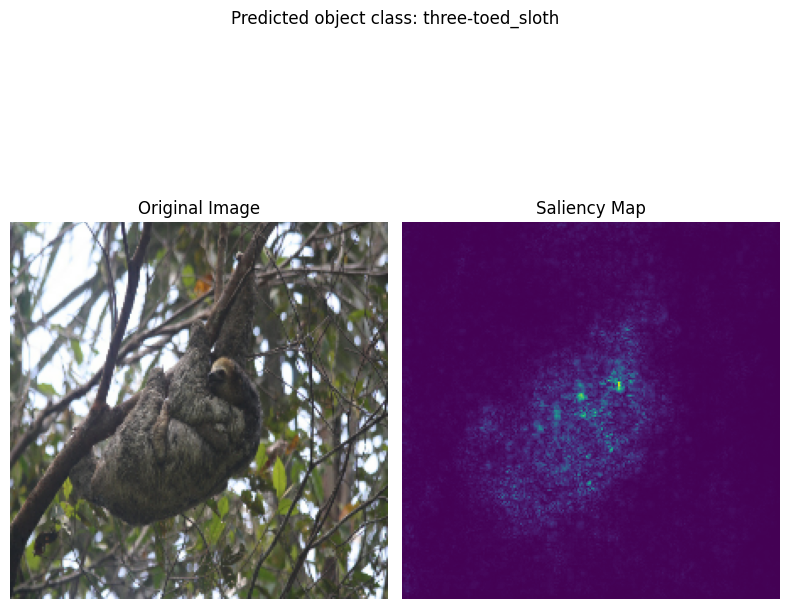

In [20]:
index = 60

# Load ResNet50 pre-trained model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

# Load dataset from ImageNetV2
dataset, info = tfds.load('imagenet_v2', with_info=True, split="test[:5%]", as_supervised=True)
for img, label in dataset.take(index):
    img = tf.image.resize(img, (224, 224))
    img = img.numpy().astype(np.float32)

# Download the ImageNet class index file
class_index_path = get_file('imagenet_class_index.json', 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')

# Load ImageNet class labels
with open(class_index_path) as f:
    class_idx = json.load(f)

# Generate saliency map
saliency_map, top_pred_index = generate_saliency_map(model, img)

# Map the index to class label
predicted_class = class_idx[str(top_pred_index)][1]

# Display the original image
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.tight_layout()

# Display the saliency map
plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='viridis')
plt.title("Saliency Map")
plt.suptitle(f"Predicted object class: {predicted_class}")
plt.axis('off')
plt.tight_layout()

plt.show()

#### Explanation

The last image here has an image of 60 and is classified as tree-toed sloth. This saliency map is even more obvious on the distinguishment between background and the object item. Here, basically only the loth and the tree branch that it is on is highlighted. The background is entirely dark and without hightlights. This shows that only the sloth (object item) is contributing to the predicted result and that the model has a significant ability in distinguishing between background and the object item.

## Conclusion on Finding

Based on the experiments on the different images above, it is fair to conclude a rejection of the null hypothesis and accept the alternative hypothesis. The alternative hypothesis is that the ResNet50 model demonstrates significant differentiation between the background and the object item in the image. All three images have most of the highlights on either the background or the object item itself on the saliency map. This aligns with the alternative hypothesis. However, this acceptance to the alternative hypothesis is only based on the three images tested here. For future improvement, more images from the dataset can be tested with salienncy map as well as other explainable deep learning methods to have more robust and well-rounded conclusion on the hypothesis testing.